In [1]:
import numpy as np
import matplotlib.pyplot as plt

from fluid_module import canonical_fibonacci_lattice, oseen_tensor_surface, oseen_tensor_on_points, force_on_sphere, discretized_sphere, field_cartesian

In [33]:
# Parameters
N_sphere = 1000
N_point = 20
squirmer_radius = 1
point_radius = 2.5 * squirmer_radius
max_mode = 2
regularization_offset = 0.01
viscosity = 1

# Modes
B = np.zeros((3, 3))
B_tilde = np.zeros_like(B)
C = np.zeros_like(B)
C_tilde = np.zeros_like(B)
#B[0,1] = 1
B_tilde[1, 1] = 1

# Points outside sphere
grid_vals = np.linspace(-point_radius, point_radius, N_point) + 0.1
x_point = np.zeros_like(grid_vals)
y_point = 1 * grid_vals
z_point = 1 * grid_vals
X, Y, Z = np.meshgrid(x_point, y_point, z_point)
R = np.sqrt(X.flatten() ** 2 + Y.flatten() ** 2 + Z.flatten() ** 2)

# Do the calculations
x_sphere, y_sphere, z_sphere, theta, phi, area = canonical_fibonacci_lattice(N_sphere, squirmer_radius)

A_oseen = oseen_tensor_on_points(x_sphere, y_sphere, z_sphere, 
                                 X.flatten(), Y.flatten(), Z.flatten(), 
                                 regularization_offset=regularization_offset, dA=area, viscosity=viscosity)

forces, u_surface = force_on_sphere(N_sphere, distance_squirmer=R, max_mode=max_mode, theta=theta, phi=phi, squirmer_radius=squirmer_radius, 
                            B=B, B_tilde=B_tilde, C=C, C_tilde=C_tilde, regularization_offset=regularization_offset,
                            viscosity=viscosity, lab_frame=True)
forces = np.expand_dims(forces, axis=1)
u_sphere = A_oseen @ forces

(3000, 3000)
u_comb shape = (3000,)
[-3.46944695e-18  7.04227597e-02  1.97231989e-01 ...  7.70454460e-02
 -4.38440119e-02  0.00000000e+00]


In [34]:
def oseen_point23(x_sphere, y_sphere, z_sphere, x_points, y_points, z_points, epsilon, dA, viscosity):
    oseen_factor = dA / (8 * np.pi * viscosity)
    
    dx = x_points[:, None] - x_sphere[None, :]
    dy = y_points[:, None] - y_sphere[None, :]
    dz = z_points[:, None] - z_sphere[None, :]
    r = np.sqrt(dx ** 2 + dy ** 2 + dz ** 2)
    r_epsilon_cubed = np.sqrt(r ** 2 + epsilon ** 2) ** 3
    
    S = (dz * dy) / r_epsilon_cubed
    return S * oseen_factor

In [35]:
oseen_tensor_on_points(x_sphere, y_sphere, z_sphere, 
                       X.flatten(), Y.flatten(), Z.flatten(), 
                       regularization_offset=regularization_offset, dA=area, viscosity=viscosity)[N_point**3:2*N_point**3, 2*N_sphere:3*N_sphere];

In [36]:
oseen_point23(x_sphere, y_sphere, z_sphere, 
              X.flatten(), Y.flatten(), Z.flatten(),
              epsilon=regularization_offset, dA=area, viscosity=viscosity);

In [37]:
# The known velocity field
y_field = 1 * y_point
z_field = 1 * z_point
Z_field, Y_field = np.meshgrid(z_field, y_field)
R_field = np.sqrt(Z_field**2 + Y_field**2)
Theta = np.arctan2(Y_field, Z_field) + np.pi
Phi = np.ones(np.shape(Theta)) * np.pi/2

ux_field, uy_field, uz_field = field_cartesian(max_mode, R_field.flatten(), Theta.flatten(), Phi.flatten(), 
                                               squirmer_radius, B, B_tilde, C, C_tilde, lab_frame=True )
ux_field = ux_field.reshape(np.shape(R_field))
uy_field = uy_field.reshape(np.shape(R_field))
uz_field = uz_field.reshape(np.shape(R_field))
#print(uy_field.reshape(np.shape(R_field)))
mask_squirmer = R_field < squirmer_radius
ux_field[mask_squirmer] = 0
uy_field[mask_squirmer] = 0
uz_field[mask_squirmer] = 0

In [38]:
u_y = u_sphere[N_point**3:2*N_point**3]
u_z = u_sphere[2*N_point**3:3*N_point**3]

u_y = u_y.reshape(N_point, N_point, N_point)
u_z = u_z.reshape(N_point, N_point, N_point)

u_y = u_y[:, 0, :]
u_z = u_z[:, 0, :]

Y_plot = Y[:, 0, :]
Z_plot = Z[:, 0, :]


In [39]:
u_y[mask_squirmer] = 0
u_z[mask_squirmer] = 0

# Shape investigation
print("N_sphere = ", N_sphere)
print("N_sphere**3 = ", N_sphere ** 3)
print("N_point =", N_point)
print("N_point**3 =", N_point ** 3)

print("")
print("u_y shape = ", np.shape(u_y))
print("Y shape = ", np.shape(Y))
print("Y_field shape = ", np.shape(Y_field))
print("")
print("Y_plot shape=", np.shape(Y_plot))

print("")
print("Oseen =", np.shape(A_oseen))
print("force =", np.shape(forces))

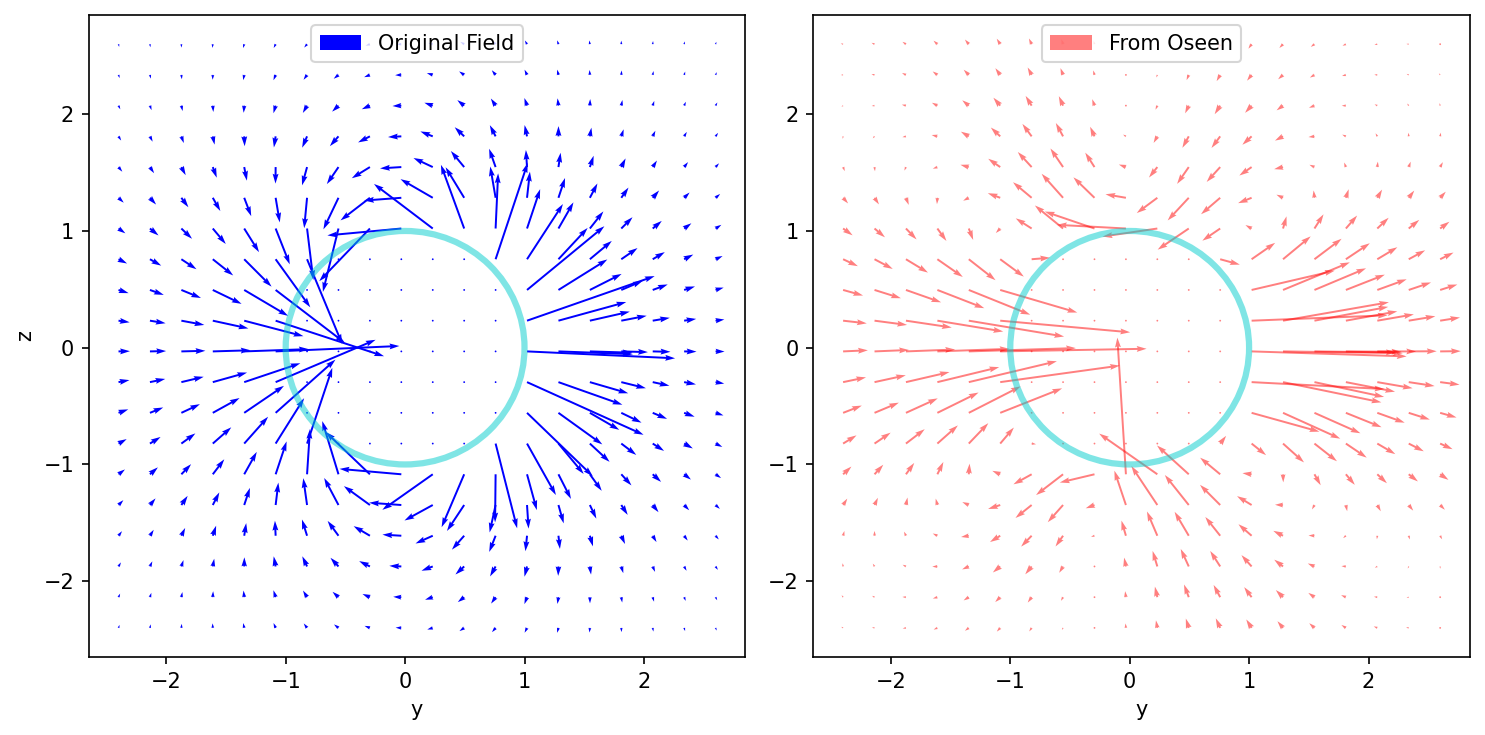

In [40]:
from matplotlib.patches import Circle
fig, ax = plt.subplots(nrows=1, ncols=2, dpi=150, figsize=(10, 5))
ax_original, ax_oseen = ax
circle1 = Circle((0, 0), radius=squirmer_radius, facecolor="none", edgecolor=(0, 0.8, 0.8), linewidth=3, alpha=0.5)
circle2 = Circle((0, 0), radius=squirmer_radius, facecolor="none", edgecolor=(0, 0.8, 0.8), linewidth=3, alpha=0.5)

# Original
ax_original.add_patch(circle1)
ax_original.quiver(Y_field, Z_field, uy_field, uz_field, color="blue", label="Original Field")
ax_original.set(xlabel="y", ylabel="z")
ax_original.legend(loc="upper center")

# From Oseen
ax_oseen.add_patch(circle2)
ax_oseen.quiver(Y_plot, Z_plot, u_y, u_z, color="red", alpha=0.5, label="From Oseen")
ax_oseen.set(xlabel="y")
ax_oseen.legend(loc="upper center")

fig.tight_layout()

In [10]:
N = 2
r = 3
a = 1
B = np.random.uniform(size=(N+1, N+1))
B_tilde = B / 2
C = B / 3
C_tilde = B / 4
theta = 0
#vals, diff = lpmn(N, N, np.cos(theta))
#print(diff)
#u_r, u_theta = field_polar(N, r, theta, a, B, B_tilde, C, C_tilde)
#print(u_r, u_theta)
x, y, z,_ = discretized_sphere(N=1000, radius=1)
fig = plt.figure(dpi=200)
ax = fig.add_subplot(projection="3d")
ax.scatter(x, y, z)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()
plt.close()

x_can, y_can, z_can, _ = canonical_fibonacci_lattice(N=1000, radius=1)
fig_1 = plt.figure(dpi=200)
ax_1 = fig_1.add_subplot(projection="3d")
ax_1.scatter(x_can, y_can, z_can)
ax_1.set_xlabel("x")
ax_1.set_ylabel("y")
ax_1.set_zlabel("z")
plt.show()
plt.close()


ValueError: too many values to unpack (expected 4)

In [ ]:
def Oseen(x, y, z, zeta_x, zeta_y, zeta_z, epsilon):
    """
    arbitary point: x,y,z 
    singular point: zeta_x, zeta_y, zeta_z,
    return the oseen matrix/tensor S which is 3x3 big
    The oseen tensor has NOT been integrated
    """
    S = np.ones((3,3))
    r1 = x - zeta_x  # distance between an arbitary point and the a singular point 
    r2 = y - zeta_y
    r3 = z - zeta_z
    
    r = np.sqrt(r1 ** 2 + r2 ** 2 + r3 ** 2)
    r_epsilon = np.sqrt(r ** 2 + epsilon ** 2)
        
    S[0, 0] = (r ** 2 + 2 * epsilon ** 2 + r1 ** 2) / r_epsilon ** 3
    S[1, 1] = (r ** 2 + 2 * epsilon ** 2 + r2 ** 2) / r_epsilon ** 3
    S[2, 2] = (r ** 2 + 2 * epsilon ** 2 + r3 ** 2) / r_epsilon ** 3
    S[0, 1] = S[1, 0] = r1 * r2 / r_epsilon ** 3
    S[0, 2] = S[2, 0] = r1 * r3 / r_epsilon ** 3
    S[1, 2] = S[2, 1] = r1 * r3 / r_epsilon ** 3
    
    return S

In [ ]:
N = 4
A = np.ones((3*N ,3*N))
B = np.ones((3*N))
print(np.shape( B))
A[0:3, 0:3] = 10 
A[0:3 , 3 :2*3 ] = 12
A[0:3 , 2*3 :3*3 ] = 33
A[0:3 , 3*3 :4*3 ] = 4

A[3:2*3,  0:3] = 58
A[2*3:3*3,  0:3] = 0
A[3*3:4*3, 0:3] = 66

A[3*3:4*3, 3*3:4*3] = 100

print(A)
print(np.shape(A @ B))
A @ B

In [ ]:
x, y, z, da = discretized_sphere(50 , 1)

ux, uy, uz = velocity(x, y,z, 1)

U = np.array((ux, uy, uz)).flatten()
print(np.shape(x))

In [ ]:
A = oseen_tensor(x, y, z, 0.01, da, 1)
np.shape(A)
